<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Credit__scoring_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The data contains several number of relational tables. We'll process each one of them separately, and then finally in the end, merge all of them together.

## **Preprocessing Tables**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Data Structures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pickle
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Download databases
app_test= pd.read_csv('/content/drive/MyDrive/p7/data/application_test.csv', encoding='utf-8', low_memory=False)
app_train= pd.read_csv('/content/drive/MyDrive/p7/data/application_train.csv',low_memory=False)

In [ ]:
bureau= pd.read_csv('/content/drive/MyDrive/p7/data/bureau.csv',sep=',', encoding='utf-8', low_memory=False)
#bureau_balance= pd.read_csv('/content/drive/MyDrive/p7/data/bureau_balance.csv',sep=',' , encoding='utf-8', low_memory=False)
#cc_balance= pd.read_csv('/content/drive/MyDrive/p7/data/credit_card_balance.csv',sep=',', encoding='utf-8', low_memory=False)

In [ ]:
install_pay= pd.read_csv('/content/drive/MyDrive/p7/data/installments_payments.csv',sep=',', encoding='utf-8', low_memory=False)

In [ ]:
pos_cash_bal= pd.read_csv('/content/drive/MyDrive/p7/data/POS_CASH_balance.csv',sep=',', encoding='utf-8', low_memory=False)

In [ ]:

previous_application= pd.read_csv('/content/drive/MyDrive/p7/data/previous_application.csv', encoding='utf-8',low_memory=False)

## **application_train and application_test**

### **Data cleaning**

In [ ]:
#there are some FLAG_DOCUMENT features having just one category for almost all data, we will remove those
flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_20']
app_train.drop(flag_cols_to_drop, axis = 1, inplace = True)
app_test.drop(flag_cols_to_drop, axis = 1, inplace= True)

#converting age from days to years
app_train['AGE'] = app_train['DAYS_BIRTH'] * -1 / 365
app_test['AGE'] = app_test['DAYS_BIRTH'] * -1 / 365

# Outliers
#From the EDA we saw some erroneous values in DAYS_EMPLOYED field
app_train['AMT_INCOME_TOTAL'][app_train['AMT_INCOME_TOTAL'] < 0.05e+07] = np.nan
app_test['AMT_INCOME_TOTAL'][app_test['AMT_INCOME_TOTAL'] < 0.05e+07] = np.nan

#From the EDA we saw some erroneous values in DAYS_EMPLOYED field
app_train['DAYS_EMPLOYED'][app_train['DAYS_EMPLOYED'] == 365243] = np.nan
app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED'] == 365243] = np.nan

#there were also 4 rows with 'XNA' as Gender, removing these rows
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

#converting columns of REGION_RATING_CLIENT to object type, as we saw some complex impact on TARGET variable during EDA
app_train['REGION_RATING_CLIENT'] = app_train['REGION_RATING_CLIENT'].astype('object')
app_train['REGION_RATING_CLIENT_W_CITY'] = app_train['REGION_RATING_CLIENT_W_CITY'].astype('object')

app_test['REGION_RATING_CLIENT'] = app_test['REGION_RATING_CLIENT'].astype('object')
app_test['REGION_RATING_CLIENT_W_CITY'] = app_test['REGION_RATING_CLIENT_W_CITY'].astype('object')


In [ ]:
app_train.shape

(307507, 118)

### Suppression des lignes qui ont un taux de remplissage inférieur à une limite

In [ ]:
find_rate =  app_train.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_lines = find_rate.shape[0]
nb_columns = find_rate.shape[1]
                
find_rate['taux_remplissage_lines'] = (app_train.apply(lambda x: x.count(), axis=1)/nb_columns)
    
filling_rate = []
remove_line = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)
    df_2 = find_rate[find_rate['taux_remplissage_lines'] > taux_remplissage]
              
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]
    remove_line.append(nb_lines_supp)
  
    del df_2['taux_remplissage_lines']
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_lines': remove_line})
find_rate

,filling_rate,remove_lines
0,0.0,0
1,10.0,0
2,20.0,0
3,30.0,0
4,40.0,0
5,50.0,70
6,60.0,132473
7,70.0,154439
8,80.0,175672
9,90.0,211526


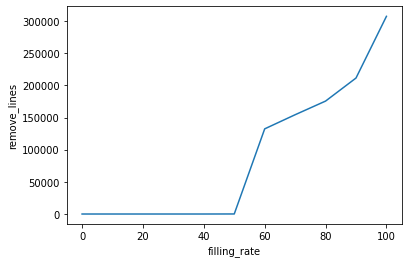

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_lines")

In [ ]:
find_rate =  app_train.copy()
def filtration_line(dataframe, taux_remplissage):
    df = dataframe.copy()

    nb_lines = find_rate.shape[0]
    nb_columns = find_rate.shape[1]

    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of line at origin
    nb_lines = dataframe.shape[0]
                
    df['taux_remplissage_lines'] = (dataframe.apply(lambda x: x.count(), axis=1)/nb_columns)

    df_2 = df[df['taux_remplissage_lines'] > taux_remplissage]
  
            
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]

    print("Number of lines with a fill rate higher than {:.2%} : {} lines.".format(taux_remplissage, df_2.shape[0]))
    print("Number of lines deleted :",nb_lines_supp)
    print("Shape of data:",df_2.shape)
    
    del df_2['taux_remplissage_lines']

    return df_2

In [ ]:
app_train_clean_lines = filtration_line(app_train, 0.6)

Number of lines with a fill rate higher than 60.00% : 175034 lines.
Number of lines deleted : 132473
Shape of data: (175034, 119)


In [ ]:
app_test_clean_lines = filtration_line(app_test, 0.6)

Number of lines with a fill rate higher than 60.00% : 26115 lines.
Number of lines deleted : 22629
Shape of data: (26115, 118)


### Suppression des colonnes qui ont un taux de remplissage inférieur à une limite

In [ ]:
find_rate = app_train_clean_lines.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_colonne = find_rate.shape[1]

filling_rate = []
remove_col = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)

    df = find_rate[find_rate.columns[1-find_rate.isnull().mean() > taux_remplissage]]
    
    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]
    
    remove_col.append(nb_colonne_supp)
  
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_columns': remove_col
    })
find_rate 


,filling_rate,remove_columns
0,0.0,0
1,10.0,0
2,20.0,0
3,30.0,0
4,40.0,1
5,50.0,1
6,60.0,18
7,70.0,18
8,80.0,28
9,90.0,56


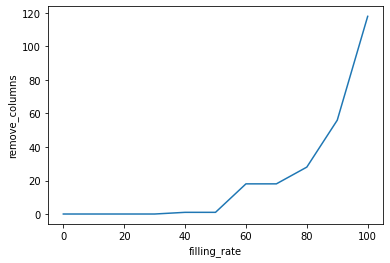

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_columns")

In [ ]:
def filtration_columns(dataframe, taux_remplissage):
    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of columns at origin
    nb_colonne = dataframe.shape[1]
    
    df = dataframe[dataframe.columns[1-dataframe.isnull().mean() > taux_remplissage]]

    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]

    print("Nombre de colonnes avec un taux de remplissage supérieur à {:.2%} : {} colonnes.".format(taux_remplissage, df.shape[1]))
    print("Nombre de colonnes supprimées : {} colonnes".format(nb_colonne_supp))

    return df

In [ ]:
app_train_reduced = filtration_columns(app_train_clean_lines, 0.6)


Nombre de colonnes avec un taux de remplissage supérieur à 60.00% : 100 colonnes.
Nombre de colonnes supprimées : 18 colonnes


In [ ]:
app_test_reduced = filtration_columns(app_test_clean_lines, 0.6)

Nombre de colonnes avec un taux de remplissage supérieur à 60.00% : 109 colonnes.
Nombre de colonnes supprimées : 8 colonnes


In [ ]:
app_train_reduced.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,...,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.00,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25.920548
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,...,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.01,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45.931507
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130.0,-1213.0,-619,1,1,0,1,1,0,Accountants,3.0,2,2,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-1562.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,37.747945
12,100016,0,Cash loans,F,N,Y,0,67500.0,80865.0,5881.5,67500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.031329,-13439,-2717.0,-311.0,-3227,1,1,1,1,1,0,Laborers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Business Entity Type 2,...,0.0833,NaN,0.9811,0.00,0.2069,0.1667,0.0137,0.0792,0.00,block of flats,0.0612,NaN,No,0.0,0.0,0.0,0.0,-2370.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,36.819178
13,100017,0,Cash loans,M,Y,N,1,225000.0,918468.0,28966.5,697500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.016612,-14086,-3028.0,-643.0,-4911,1,1,0,1,0,0,Drivers,3.0,2,2,THURSDAY,13,0,0,0,0,0,0,Self-employed,...,0.1489,0.0973,0.9806,0.16,0.1379,0.3333,0.0947,0.1422,0.00,block of flats,0.1417,Panel,No,0.0,0.0,0.0,0.0,-4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,38.591781


In [ ]:
app_train_reduced.shape

(175034, 100)

In [ ]:
"""#Keeping the importanr columns

# Normalized score from external data source.
if 'EXT_SOURCE_1' in app_train_reduced.columns:
    print("The column EXT_SOURCE_1 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_1'] = app_train_clean_lines['EXT_SOURCE_1']
    print("The column EXT_SOURCE_1 has been added to the dataset.")

if 'EXT_SOURCE_2' in app_train_reduced.columns:
    print("The column EXT_SOURCE_2 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_2'] = app_train_clean_lines['EXT_SOURCE_2']
    print("The column EXT_SOURCE_2 has been added to the dataset.")
    
if 'EXT_SOURCE_3' in app_train_reduced.columns:
    print("The column EXT_SOURCE_3 is in the datatset.")
else :
    app_train_reduced['EXT_SOURCE_3'] = app_train_clean_lines['EXT_SOURCE_3']
    print("The column EXT_SOURCE_3 has been added to the dataset.")
#----------------------------------------------------------------------------    

if 'DAYS_EMPLOYED' in app_train_reduced.columns:
    print("The column DAYS_EMPLOYED is in the datatset.")
else :
    app_train_reduced['DAYS_EMPLOYED'] = app_train_clean_lines['DAYS_EMPLOYED']
    print("The column DAYS_EMPLOYED has been added to the dataset.")
#----------------------------------------------------------------------------    
    
if 'DAYS_BIRTH' in app_train_reduced.columns:
    print("The column DAYS_BIRTH is in the datatset.")
else :
    app_train_reduced['DAYS_BIRTH'] = app_train_clean_lines['DAYS_BIRTH']
    print("The column DAYS_BIRTH has been added to the dataset.")
    
#----------------------------------------------------------------------------    

if 'AGE' in app_train_reduced.columns:
    print("The column AGE is in the datatset.")
else :
    app_train_reduced['AGE'] = app_train_clean_lines['AGE']
    print("The column AGE has been added to the dataset.")"""

The column EXT_SOURCE_1 has been added to the dataset.
The column EXT_SOURCE_2 is in the datatset.
The column EXT_SOURCE_3 is in the datatset.
The column DAYS_EMPLOYED is in the datatset.
The column DAYS_BIRTH is in the datatset.
The column AGE is in the datatset.


In [ ]:
app_train_reduced.shape

(175034, 100)

In [ ]:
app_test_reduced.shape

(26115, 109)

In [ ]:
"""# Remove columns with more than 60% of null values
def remove_column(df):
   column_with_nan = df.columns[df.isnull().any()]
   for column in column_with_nan:
     if df[column].isnull().sum()*100.0/df.shape[0] > 60:
       df.drop(column,1, inplace=True)
   return (df)"""

In [ ]:
# remove all the columns which are not in app_train
filter_columns = list(app_train_reduced.columns)

def remove_columns(dataframe, filter_columns):
    """dataframe : dataframe to filter
    filter_columns : columns to keep"""
    new = pd.DataFrame()

    for column in filter_columns:
        try:
            new[column] = dataframe[column]
        except:
            print('...colonne non présente : ', column)
            print('\n')
    print("All selected columns have been kept from the dataset")
    return new

In [ ]:
app_test_reduced = remove_columns(app_test_clean_lines, filter_columns)

...colonne non présente :  TARGET


All selected columns have been kept from the dataset


In [ ]:
set(app_test_reduced.columns).difference(set(app_train_reduced.columns))

set()

In [ ]:
set(app_train_reduced.columns).difference(set(app_test_reduced.columns))

{'TARGET'}

In [ ]:
app_test_reduced.shape

(26115, 99)

### **Feature Engineering**

In [ ]:
app_train['AMT_INCOME_TOTAL'].max()

0         202500.0
1         270000.0
2          67500.0
3         135000.0
4         121500.0
            ...   
307506    157500.0
307507     72000.0
307508    153000.0
307509    171000.0
307510    157500.0
Name: AMT_INCOME_TOTAL, Length: 307507, dtype: float64

In [ ]:
app_train['AMT_CREDIT']

0          406597.5
1         1293502.5
2          135000.0
3          312682.5
4          513000.0
            ...    
307506     254700.0
307507     269550.0
307508     677664.0
307509     370107.0
307510     675000.0
Name: AMT_CREDIT, Length: 307507, dtype: float64

In [ ]:
app_train['AMT_ANNUITY']

0         24700.5
1         35698.5
2          6750.0
3         29686.5
4         21865.5
           ...   
307506    27558.0
307507    12001.5
307508    29979.0
307509    20205.0
307510    49117.5
Name: AMT_ANNUITY, Length: 307507, dtype: float64

In [ ]:
app_train['EXT_SOURCE_3'].max()


0.8960095494948396

In [ ]:
app_train['EXT_SOURCE_3'].min()

0.0005272652387098

In [ ]:
def feature_engineering(data):
        
  #income and credit features
  data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] )
  data['ANNUITY_CREDIT_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_CREDIT'] )       #   Credit amount of the loan
  data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']    #  loan annuity/ income total

  data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] )

  #age ratios and diffs
  data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'])

  #family members
  data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'])   
  data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'])   # Capital income of family

  #details change
  data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
  data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
              
  return data

In [ ]:
#Creating Numeric features based on domain knowledge
app_train_reduced = feature_engineering(app_train_reduced)
app_test_reduced = feature_engineering(app_test_reduced)

In [ ]:
app_train_reduced.shape

(175034, 109)

In [ ]:
app_test_reduced.shape

(26115, 108)

### **Imputation**

* **Train**

In [ ]:
"""#Imputation with pandas 
def imputation_pandas(dataframe):
  short_cleaned_impute = dataframe.copy()
  for col_name in dataframe:
    short_cleaned_impute[col_name] = dataframe[col_name].interpolate(method='linear', inplace=False, limit_direction="both").ffill().bfill()
    
  return short_cleaned_impute"""

In [ ]:
# Imputaion with mod & median
def filling_nan_value(df):
  column_with_nan = df.columns[df.isnull().any()]
  for column in column_with_nan:
    if df[column].dtypes=='O':
      df[column]= df[column].fillna(df[column].mode()[0])
    else:
      df[column]= df[column].fillna(df[column].median())
  return (df)

In [ ]:
app_train_reduced.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [ ]:
app_train_final = filling_nan_value(app_train_reduced)
app_test_final = filling_nan_value(app_test_reduced)

In [ ]:
app_train_final.isnull().sum().sort_values(ascending=False)

SK_ID_CURR                     0
HOUSETYPE_MODE                 0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_3                0
                              ..
REG_REGION_NOT_LIVE_REGION     0
HOUR_APPR_PROCESS_START        0
WEEKDAY_APPR_PROCESS_START     0
REGION_RATING_CLIENT_W_CITY    0
DAYS_DETAILS_CHANGE_SUM        0
Length: 109, dtype: int64

In [ ]:
app_test_final.isnull().sum().sort_values(ascending=False)

SK_ID_CURR                     0
HOUSETYPE_MODE                 0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_3                0
                              ..
REG_REGION_NOT_LIVE_REGION     0
HOUR_APPR_PROCESS_START        0
WEEKDAY_APPR_PROCESS_START     0
REGION_RATING_CLIENT_W_CITY    0
DAYS_DETAILS_CHANGE_SUM        0
Length: 108, dtype: int64

### **Standardisation (Train + Test)**

In [ ]:
"""df_num_train = app_train_final.select_dtypes(['number']).reset_index(drop = True)  # numerical part
df_categ_train = app_train_final.select_dtypes('object').reset_index(drop = True)   # categorical part

df_num_test = app_test_final.select_dtypes(['number']).reset_index(drop = True)   # numerical part
df_categ_test = app_test_final.select_dtypes('object').reset_index(drop = True)   # categorical part"""

In [ ]:
# for numerical part using standardScaler _TRAIN
scaler = StandardScaler()
scaler.fit(df_num_train)

df_num_train_train = pd.DataFrame(scaler.transform(df_num_train), index= df_num_train.index, columns=df_num_train.columns)

In [ ]:
# for numerical part using standardScaler _TEST
scaler = StandardScaler()
scaler.fit(df_num_test)

df_num_test_test = pd.DataFrame(scaler.transform(df_num_test), index= df_num_test.index, columns=df_num_test.columns)

In [ ]:
# concate normalization data with categorical one
df_app_train = pd.concat([df_categ_train, df_num_train_train], axis=1)
df_app_test = pd.concat([df_categ_test, df_num_test_test], axis=1)

In [ ]:
df_app_train.shape

(175034, 109)

In [ ]:
df_app_test.shape

(26115, 108)

### **Encoding (Train + Test)**

for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot.

In [ ]:
df_app_train =app_train_final.copy()
df_app_test =app_test_final.copy()

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0
ohe_count = 0

# Iterate through the columns
for col in df_app_train:
    if col == 'TARGET' or col == 'SK_ID_CURR':
        pass
    else :
        if df_app_train[col].dtype == 'object':        
        # If 2 or fewer unique categories
            if len(list(df_app_train[col].unique())) <= 2:
                # Train on the training data
                le.fit(df_app_train[col])
                # Transform both training and testing data
                df_app_train[col] = le.transform(df_app_train[col])
                df_app_test[col] = le.transform(df_app_test[col])
            
            # Keep track of how many columns were label encoded
                le_count += 1
                
            else :
                #else : one hot encoding
                df_app_train = pd.get_dummies(df_app_train, prefix=[col], columns=[col])
                df_app_test = pd.get_dummies(df_app_test, prefix=[col], columns=[col])
                ohe_count += 1
                
print('%d columns were label encoded.' % le_count)
print('Training Features shape: ', df_app_train.shape)
print('Testing Features shape: ', df_app_test.shape)
print('%d columns were one hot encoded.' % ohe_count)

5 columns were label encoded.
Training Features shape:  (175034, 228)
Testing Features shape:  (26115, 223)
12 columns were one hot encoded.


There must be the same characteristics (columns) in the training and test data. The encoding created more columns in the training data because some categorical variables had more unrepresented categories than in the test data. To remove the columns in the training data that are not in the test data, we need to align the dataframes. First, we extract the target column from the training data (because it is not in the test data but we need to keep this information). When we do the alignment, we need to make sure to set axis=1 to align the dataframes to the columns and not the rows.

In [ ]:
train_labels = df_app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_app_train, df_app_test = df_app_train.align(df_app_test, join = 'inner', axis = 1)

# Add the target back in
df_app_train['TARGET'] = train_labels

print('Training Features shape: ', df_app_train.shape)
print('Testing Features shape: ', df_app_test.shape)

Training Features shape:  (175034, 224)
Testing Features shape:  (26115, 223)


In [ ]:
"""app_train_final.to_csv("/content/drive/MyDrive/p7/data/train_imputed_with_standardisation.csv", index=False)
app_test_final.to_csv("/content/drive/MyDrive/p7/data/test_imputed_with_standardisation.csv", index=False)"""

**Backup CSVs**

In [ ]:
df_app_train.to_csv("/content/drive/MyDrive/p7/data/df_train_imputed.csv", index=False)
df_app_test.to_csv("/content/drive/MyDrive/p7/data/df_test_imputed.csv", index=False)

## **bureau_balance.csv and bureau.csv**

**bureau_balance Preprocessing**

This table consists of Monthly balance of each credit for each of the previous credit that the client had with financial institutions other than Home Credit

In [ ]:
bureau_balance.isnull().sum().sort_values(ascending=False)

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [ ]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
# Month of balance relative to application date (-1 means the freshest balance date)
bureau_balance.MONTHS_BALANCE.unique()

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64,
       -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77,
       -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89, -90,
       -91, -92, -93, -94, -95, -96])

C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off.


* bureau_balance table contains three fields, i.e. SK_ID_BUREAU, MONTHS_BALANCE and STATUS.
Since the **Status** follows somewhat ordinal behaviour, we start by **label encoding** it.
* Next, some features are created such as weighted status, which is obtained by dividing the status by the MONTHS_BALANCE.
* Since the data contains the timeseries, we also calculate the Exponential Weighted Moving Average of the Status and Weighted Status fields.
* Finally, we aggregate the data over SK_ID_BUREAU, in such a way that we first aggregate it over all the data, and after that we also aggregate over the last 2 years. These 2 years would depict the more recent behaviour of the clients.
* The aggregations performed are based on Domain Knowledge, such as mean, min, max, sum, count, etc. For EDA features, we only take the last/most recent values, as they somewhat contain the trend of all the previous values.



In [ ]:
#as we saw from EDA, bureau_balance has a variable called STATUS, which describes about the status of loan.
#it has 7 labels, we will label encode them
#so we give C as 0, and rest increasing
#also we will give X the benefit of doubt and keep it as middle value
dict_for_status = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

#weighing the status with the months_balance
#converting months to positive
bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
bureau_balance['WEIGHTED_STATUS'] = bureau_balance.STATUS / (bureau_balance.MONTHS_BALANCE + 1)

In [ ]:
#sorting the bureau_balance in ascending order of month and by the bureau SK_ID
#this is done so as to make the rolling exponential average easily for previous months till current month
bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0, 0])


In [ ]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,WEIGHTED_STATUS
23544064,6842888,61,1,0.016129
23544063,6842888,60,1,0.016393
23544062,6842888,59,1,0.016667
23544061,6842888,58,2,0.033898
23544060,6842888,57,1,0.017241
...,...,...,...,...
26079757,5001709,4,0,0.000000
26079756,5001709,3,0,0.000000
26079755,5001709,2,0,0.000000
26079754,5001709,1,0,0.000000


**exponential weighted average**

In [ ]:
#we will do exponential weighted average on the encoded status
#this is because if a person had a bad status 2 years ago, it should be given less weightage today
# we keep the latent variable alpha = 0.8 
#doing this for both weighted status and the status itself
bureau_balance['EXP_WEIGHTED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['WEIGHTED_STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())
bureau_balance['EXP_ENCODED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())

In [ ]:
bureau_balance['EXP_WEIGHTED_STATUS']

23544064    1.612903e-02
23544063    1.634937e-02
23544062    1.660526e-02
23544061    3.046187e-02
23544060    1.988209e-02
                ...     
26079757    2.217031e-59
26079756    4.434062e-60
26079755    8.868123e-61
26079754    1.773625e-61
26079753    3.547249e-62
Name: EXP_WEIGHTED_STATUS, Length: 27299925, dtype: float64

In [ ]:
#we can see that these datapoints are for 96 months i.e. 8 years.
#so we will extract the means, and exponential averages for each year separately
#first we convert month to year
bureau_balance['YEAR_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

#defining our aggregations
aggregations_basic = {'YEAR_BALANCE' : ['mean','max'],
                      'STATUS' : ['mean','max','first'],
                      'WEIGHTED_STATUS' : ['mean','sum','first'],
                      'EXP_ENCODED_STATUS' : ['last'],
                      'EXP_WEIGHTED_STATUS' : ['last']}

#we will be finding aggregates for each year too
aggregations_for_year = {'STATUS' : ['mean','max','last','first'],
                        'WEIGHTED_STATUS' : ['mean','max', 'first','last'],
                        'EXP_WEIGHTED_STATUS' : ['last'],
                        'EXP_ENCODED_STATUS' : ['last'] }

#aggregating over whole dataset first
aggregated_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_basic)
aggregated_bureau_balance.columns = ['_'.join(ele).upper() for ele in aggregated_bureau_balance.columns]

#aggregating some of the features separately for latest 2 years
aggregated_bureau_years = pd.DataFrame()
for year in range(2):
    year_group = bureau_balance[bureau_balance['YEAR_BALANCE'] == year].groupby('SK_ID_BUREAU').agg(aggregations_for_year)
    year_group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in year_group.columns]

    if year == 0:
        aggregated_bureau_years = year_group
    else:
        aggregated_bureau_years = aggregated_bureau_years.merge(year_group, on = 'SK_ID_BUREAU', how = 'outer')

#aggregating for rest of the years
aggregated_bureau_rest_years = bureau_balance[bureau_balance.MONTHS_BALANCE > year].groupby(['SK_ID_BUREAU']).agg(aggregations_for_year)
aggregated_bureau_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in aggregated_bureau_rest_years.columns]


In [ ]:
aggregated_bureau_balance.columns

Index(['YEAR_BALANCE_MEAN', 'YEAR_BALANCE_MAX', 'STATUS_MEAN', 'STATUS_MAX',
       'STATUS_FIRST', 'WEIGHTED_STATUS_MEAN', 'WEIGHTED_STATUS_SUM',
       'WEIGHTED_STATUS_FIRST', 'EXP_ENCODED_STATUS_LAST',
       'EXP_WEIGHTED_STATUS_LAST'],
      dtype='object')

In [ ]:
aggregated_bureau_rest_years.head()

,STATUS_MEAN_YEAR_REST,STATUS_MAX_YEAR_REST,STATUS_LAST_YEAR_REST,STATUS_FIRST_YEAR_REST,WEIGHTED_STATUS_MEAN_YEAR_REST,WEIGHTED_STATUS_MAX_YEAR_REST,WEIGHTED_STATUS_FIRST_YEAR_REST,WEIGHTED_STATUS_LAST_YEAR_REST,EXP_WEIGHTED_STATUS_LAST_YEAR_REST,EXP_ENCODED_STATUS_LAST_YEAR_REST
SK_ID_BUREAU,,,,,,,,,,
5001709,0.463158,4,0,4,0.005040,0.045977,0.041237,0.000000,8.868123e-61,7.737125e-59
5001710,1.543210,4,0,4,0.023249,0.080000,0.048193,0.000000,2.104770e-34,1.041593e-32
5001711,1.000000,1,1,1,0.291667,0.333333,0.250000,0.333333,3.194444e-01,1.000000e+00
5001712,0.588235,1,0,1,0.042281,0.100000,0.052632,0.000000,1.252056e-06,1.280000e-05
5001713,4.000000,4,4,4,0.438163,1.333333,0.181818,1.333333,1.257421e+00,4.000000e+00


In [ ]:
aggregated_bureau_rest_years.shape

(803466, 10)

In [ ]:
aggregated_bureau_rest_years.isnull().sum()

STATUS_MEAN_YEAR_REST                 0
STATUS_MAX_YEAR_REST                  0
STATUS_LAST_YEAR_REST                 0
STATUS_FIRST_YEAR_REST                0
WEIGHTED_STATUS_MEAN_YEAR_REST        0
WEIGHTED_STATUS_MAX_YEAR_REST         0
WEIGHTED_STATUS_FIRST_YEAR_REST       0
WEIGHTED_STATUS_LAST_YEAR_REST        0
EXP_WEIGHTED_STATUS_LAST_YEAR_REST    0
EXP_ENCODED_STATUS_LAST_YEAR_REST     0
dtype: int64

In [ ]:
aggregated_bureau_balance.to_csv("/content/drive/MyDrive/p7/data/aggregated_bureau_balance.csv", index=False)
aggregated_bureau_rest_years.to_csv("/content/drive/MyDrive/p7/data/aggregated_bureau_rest_years.csv", index=False)

## **bureau**
* Firstly, we merge the bureau table with the aggregated bureau_balance table from previous step, on SK_ID_BUREAU.
* We replace some erroneous values with NaN values. We saw some loans dating back to as long as 100 years ago. We believe they wouldn't really tell much about client's recent behaviour, so we remove them and only keep the loans in the period of 50 years.
* We create some features by multiplications, divisions, subtractions of raw features, based on domain knowledge, such as Credit duration, annutiy to credit ratio, etc.
* The categorical features are one-hot encoded.
* To merge these to main table, i.e. application_train, we aggregate this table over SK_ID_CURR. We perform the aggregations again in two ways. We aggregate the credits based on the CREDIT_ACTIVE category, where we aggregate for two most popular categories separately, i.e. Active, and Closed. Later we aggregate for the remaining categories too, and merge these. We aggregated the whole data overall too. The aggregations performed are sum, mean, min, max, last, etc.

In [ ]:
bureau.shape

(1716428, 17)

In [ ]:
bureau.isnull().sum().sort_values(ascending= False).head(5)

AMT_ANNUITY               1226791
AMT_CREDIT_MAX_OVERDUE    1124488
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_DEBT        257669
dtype: int64

In [ ]:
find_rate =  bureau.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_lines = find_rate.shape[0]
nb_columns = find_rate.shape[1]
                
find_rate['taux_remplissage_lines'] = (bureau.apply(lambda x: x.count(), axis=1)/nb_columns)
    
filling_rate = []
remove_line = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)
    df_2 = find_rate[find_rate['taux_remplissage_lines'] > taux_remplissage]
              
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]
    remove_line.append(nb_lines_supp)
  
    del df_2['taux_remplissage_lines']
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_lines': remove_line})
find_rate

,filling_rate,remove_lines
0,0.0,0
1,10.0,0
2,20.0,0
3,30.0,0
4,40.0,0
5,50.0,0
6,60.0,118194
7,70.0,457924
8,80.0,1619003
9,90.0,1716428


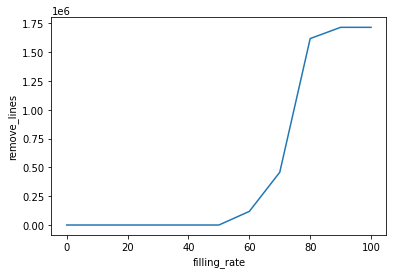

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_lines")

In [ ]:
find_rate =  bureau.copy()
def filtration_line(dataframe, taux_remplissage):
    df = dataframe.copy()

    nb_lines = find_rate.shape[0]
    nb_columns = find_rate.shape[1]

    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of line at origin
    nb_lines = dataframe.shape[0]
                
    df['taux_remplissage_lines'] = (dataframe.apply(lambda x: x.count(), axis=1)/nb_columns)

    df_2 = df[df['taux_remplissage_lines'] > taux_remplissage]
  
            
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]

    print("Number of lines with a fill rate higher than {:.2%} : {} lines.".format(taux_remplissage, df_2.shape[0]))
    print("Number of lines deleted :",nb_lines_supp)
    print("Shape of data:",df_2.shape)
    
    del df_2['taux_remplissage_lines']

    return df_2

In [ ]:
bureau = filtration_line(bureau, 0.7)

Number of lines with a fill rate higher than 70.00% : 1706518 lines.
Number of lines deleted : 9910
Shape of data: (1706518, 18)


### **Suppression des colonnes qui ont un taux de remplissage inférieur à une limite**

In [ ]:
find_rate = bureau.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_colonne = find_rate.shape[1]

filling_rate = []
remove_col = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)

    df = find_rate[find_rate.columns[1-find_rate.isnull().mean() > taux_remplissage]]
    
    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]
    
    remove_col.append(nb_colonne_supp)
  
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_columns': remove_col
    })
find_rate

,filling_rate,remove_columns
0,0.0,0
1,10.0,3
2,20.0,3
3,30.0,3
4,40.0,4
5,50.0,5
6,60.0,5
7,70.0,5
8,80.0,5
9,90.0,6


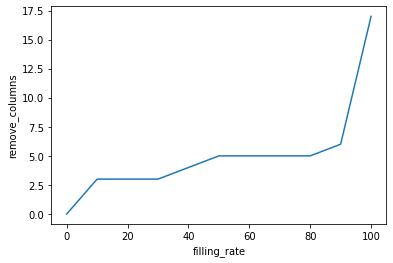

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_columns")

In [ ]:
def filtration_columns(dataframe, taux_remplissage):
    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of columns at origin
    nb_colonne = dataframe.shape[1]
    
    df = dataframe[dataframe.columns[1-dataframe.isnull().mean() > taux_remplissage]]

    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]

    print("Nombre de colonnes avec un taux de remplissage supérieur à {:.2%} : {} colonnes.".format(taux_remplissage, df.shape[1]))
    print("Nombre de colonnes supprimées : {} colonnes".format(nb_colonne_supp))

    return df

In [ ]:
bureau = filtration_columns(bureau, 0.8)

Nombre de colonnes avec un taux de remplissage supérieur à 80.00% : 13 colonnes.
Nombre de colonnes supprimées : 4 colonnes


In [ ]:
bureau.shape

(1706518, 13)

In [ ]:
# Imputaion with mod & median
def filling_nan_value(df):
  column_with_nan = df.columns[df.isnull().any()]
  for column in column_with_nan:
    if df[column].dtypes=='O':
      df[column]= df[column].fillna(df[column].mode()[0])
    else:
      df[column]= df[column].fillna(df[column].median())
  return (df)

In [ ]:
bureau_final = filling_nan_value(bureau)

In [ ]:
bureau_final.keys()

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE'],
      dtype='object')

In [ ]:
#from the EDA we saw some erroneous values in DAYS Fields, we will remove those
#there are some loans which ended about very long ago, around 100 years ago.
#Thus we will only keep those loans which have ended in past 50 years.
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] > -50 *365] = np.nan

#there is also a feature which tells about the number of days ago the Credit Report Came
bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] > -50 *365] = np.nan

**Feature engineering**

In [ ]:
bureau_final['DAYS_CREDIT']

0          -497
1          -208
2          -203
4          -629
5          -273
           ... 
1716423     -44
1716424   -2648
1716425   -1809
1716426   -1878
1716427    -463
Name: DAYS_CREDIT, Length: 1706518, dtype: int64

In [ ]:
#engineering some features based on domain knowledge
bureau_final['CREDIT_DURATION'] = np.abs(bureau_final['DAYS_CREDIT'] - bureau_final['DAYS_CREDIT_ENDDATE'])

bureau_final['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = bureau_final['AMT_CREDIT_SUM_OVERDUE'] / (bureau_final['CREDIT_DURATION'])

In [ ]:
bureau_final.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,CREDIT_DURATION,CURRENT_AMT_OVERDUE_DURATION_RATIO
0,215354,5714462,Closed,currency 1,-497,0,NaN,0,91323.0,0.00,0.0,Consumer credit,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,NaN,0,225000.0,171342.00,0.0,Credit card,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,NaN,0,464323.5,0.00,0.0,Consumer credit,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,NaN,0,2700000.0,0.00,0.0,Consumer credit,NaN,NaN,NaN
5,215354,5714467,Active,currency 1,-273,0,NaN,0,180000.0,71017.38,0.0,Credit card,NaN,NaN,NaN


In [ ]:
bureau_final.shape

(1706518, 15)

In [ ]:
#now we will be aggregating the bureau_merged df with respect to 'SK_ID_CURR' so as to merge it with application_train later    
#firstly we will aggregate the columns based on the category of CREDIT_ACTIVE
aggregations_CREDIT_ACTIVE = {
                              'DAYS_CREDIT' : ['mean','min','max','last'],
                              'CREDIT_DAY_OVERDUE' : ['mean','max'],
                              'DAYS_CREDIT_ENDDATE' : ['mean','max'],
                              'DAYS_ENDDATE_FACT' : ['mean','min'],
                              'AMT_CREDIT_MAX_OVERDUE': ['max','sum'],
                              'CNT_CREDIT_PROLONG': ['max','sum'],
                              'AMT_CREDIT_SUM' : ['sum','max'],
                              'AMT_CREDIT_SUM_DEBT': ['sum'],
                              'AMT_CREDIT_SUM_LIMIT': ['max','sum'],
                              'AMT_CREDIT_SUM_OVERDUE': ['max','sum'],
                              
                              'AMT_ANNUITY' : ['mean','sum','max'],
                              'CREDIT_DURATION' : ['max','mean'],
                              
                              'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                              'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                              'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max', 'mean'],
                              'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                              'CURRENT_CREDIT_DEBT_DIFF' : ['mean','min'],
                              'AMT_ANNUITY_CREDIT_RATIO' : ['mean','max','min'],
                              
                              'STATUS_MEAN' : ['mean', 'max'],
                              'WEIGHTED_STATUS_MEAN' : ['mean', 'max']
                                }

In [ ]:
bureau_final['CREDIT_ACTIVE']

0          Closed
1          Active
2          Active
4          Active
5          Active
            ...  
1716423    Active
1716424    Closed
1716425    Closed
1716426    Closed
1716427    Closed
Name: CREDIT_ACTIVE, Length: 1706518, dtype: object

In [ ]:
#we saw from EDA that the two most common type of CREDIT ACTIVE were 'Closed' and 'Active'.
#So we will aggregate them two separately and the remaining categories separately.
categories_to_aggregate_on = ['Closed','Active']
bureau_merged_aggregated_credit = pd.DataFrame()
for i, status in enumerate(categories_to_aggregate_on):
    group = bureau_merged[bureau_final['CREDIT_ACTIVE'] == status].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
    group.columns = ['_'.join(ele).upper() + '_CREDITACTIVE_' + status.upper() for ele in group.columns]

    if i==0:
        bureau_merged_aggregated_credit = group
    else:
        bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(group, on = 'SK_ID_CURR', how = 'outer')
#aggregating for remaining categories
bureau_merged_aggregated_credit_rest = bureau_merged[(bureau_merged['CREDIT_ACTIVE'] != 'Active') & 
                                                      (bureau_merged['CREDIT_ACTIVE'] != 'Closed')].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
bureau_merged_aggregated_credit_rest.columns = ['_'.join(ele).upper() + 'CREDIT_ACTIVE_REST' for ele in bureau_merged_aggregated_credit_rest.columns]

#merging with other categories
bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(bureau_merged_aggregated_credit_rest, on = 'SK_ID_CURR', how = 'outer')

#Encoding the categorical columns in one-hot form
currency_ohe = pd.get_dummies(bureau_merged['CREDIT_CURRENCY'], prefix = 'CURRENCY')
credit_active_ohe = pd.get_dummies(bureau_merged['CREDIT_ACTIVE'], prefix = 'CREDIT_ACTIVE')
credit_type_ohe = pd.get_dummies(bureau_merged['CREDIT_TYPE'], prefix = 'CREDIT_TYPE')

#merging the one-hot encoded columns
bureau_merged = pd.concat([bureau_merged.drop(['CREDIT_CURRENCY','CREDIT_ACTIVE','CREDIT_TYPE'], axis = 1), 
                            currency_ohe, credit_active_ohe, credit_type_ohe], axis = 1)

#aggregating the bureau_merged over all the columns
bureau_merged_aggregated = bureau_merged.drop('SK_ID_BUREAU', axis = 1).groupby('SK_ID_CURR').agg('mean')
bureau_merged_aggregated.columns = [ele + '_MEAN_OVERALL' for ele in bureau_merged_aggregated.columns]
#merging it with aggregates over categories
bureau_merged_aggregated = bureau_merged_aggregated.merge(bureau_merged_aggregated_credit, on = 'SK_ID_CURR', how = 'outer')

KeyError: ignored

In [ ]:
bureau_merged_aggregated.head()

,DAYS_CREDIT_MEAN_OVERALL,CREDIT_DAY_OVERDUE_MEAN_OVERALL,DAYS_CREDIT_ENDDATE_MEAN_OVERALL,DAYS_ENDDATE_FACT_MEAN_OVERALL,AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL,CNT_CREDIT_PROLONG_MEAN_OVERALL,AMT_CREDIT_SUM_MEAN_OVERALL,AMT_CREDIT_SUM_DEBT_MEAN_OVERALL,AMT_CREDIT_SUM_LIMIT_MEAN_OVERALL,AMT_CREDIT_SUM_OVERDUE_MEAN_OVERALL,DAYS_CREDIT_UPDATE_MEAN_OVERALL,AMT_ANNUITY_MEAN_OVERALL,YEAR_BALANCE_MEAN_MEAN_OVERALL,YEAR_BALANCE_MAX_MEAN_OVERALL,STATUS_MEAN_MEAN_OVERALL,STATUS_MAX_MEAN_OVERALL,STATUS_FIRST_MEAN_OVERALL,WEIGHTED_STATUS_MEAN_MEAN_OVERALL,WEIGHTED_STATUS_SUM_MEAN_OVERALL,WEIGHTED_STATUS_FIRST_MEAN_OVERALL,EXP_ENCODED_STATUS_LAST_MEAN_OVERALL,EXP_WEIGHTED_STATUS_LAST_MEAN_OVERALL,CREDIT_DURATION_MEAN_OVERALL,FLAG_OVERDUE_RECENT_MEAN_OVERALL,MAX_AMT_OVERDUE_DURATION_RATIO_MEAN_OVERALL,CURRENT_AMT_OVERDUE_DURATION_RATIO_MEAN_OVERALL,AMT_OVERDUE_DURATION_LEFT_RATIO_MEAN_OVERALL,CNT_PROLONGED_MAX_OVERDUE_MUL_MEAN_OVERALL,CNT_PROLONGED_DURATION_RATIO_MEAN_OVERALL,CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_OVERALL,CURRENT_CREDIT_DEBT_DIFF_MEAN_OVERALL,AMT_ANNUITY_CREDIT_RATIO_MEAN_OVERALL,CREDIT_ENDDATE_UPDATE_DIFF_MEAN_OVERALL,CURRENCY_currency 1_MEAN_OVERALL,CURRENCY_currency 2_MEAN_OVERALL,CURRENCY_currency 3_MEAN_OVERALL,CURRENCY_currency 4_MEAN_OVERALL,CREDIT_ACTIVE_Active_MEAN_OVERALL,CREDIT_ACTIVE_Bad debt_MEAN_OVERALL,CREDIT_ACTIVE_Closed_MEAN_OVERALL,...,CNT_CREDIT_PROLONG_MAXCREDIT_ACTIVE_REST,CNT_CREDIT_PROLONG_SUMCREDIT_ACTIVE_REST,AMT_CREDIT_SUM_SUMCREDIT_ACTIVE_REST,AMT_CREDIT_SUM_MAXCREDIT_ACTIVE_REST,AMT_CREDIT_SUM_DEBT_SUMCREDIT_ACTIVE_REST,AMT_CREDIT_SUM_LIMIT_MAXCREDIT_ACTIVE_REST,AMT_CREDIT_SUM_LIMIT_SUMCREDIT_ACTIVE_REST,AMT_CREDIT_SUM_OVERDUE_MAXCREDIT_ACTIVE_REST,AMT_CREDIT_SUM_OVERDUE_SUMCREDIT_ACTIVE_REST,DAYS_CREDIT_UPDATE_MEANCREDIT_ACTIVE_REST,DAYS_CREDIT_UPDATE_MINCREDIT_ACTIVE_REST,AMT_ANNUITY_MEANCREDIT_ACTIVE_REST,AMT_ANNUITY_SUMCREDIT_ACTIVE_REST,AMT_ANNUITY_MAXCREDIT_ACTIVE_REST,CREDIT_DURATION_MAXCREDIT_ACTIVE_REST,CREDIT_DURATION_MEANCREDIT_ACTIVE_REST,FLAG_OVERDUE_RECENT_SUMCREDIT_ACTIVE_REST,MAX_AMT_OVERDUE_DURATION_RATIO_MAXCREDIT_ACTIVE_REST,MAX_AMT_OVERDUE_DURATION_RATIO_SUMCREDIT_ACTIVE_REST,CURRENT_AMT_OVERDUE_DURATION_RATIO_MAXCREDIT_ACTIVE_REST,CURRENT_AMT_OVERDUE_DURATION_RATIO_SUMCREDIT_ACTIVE_REST,AMT_OVERDUE_DURATION_LEFT_RATIO_MAXCREDIT_ACTIVE_REST,AMT_OVERDUE_DURATION_LEFT_RATIO_MEANCREDIT_ACTIVE_REST,CNT_PROLONGED_MAX_OVERDUE_MUL_MEANCREDIT_ACTIVE_REST,CNT_PROLONGED_MAX_OVERDUE_MUL_MAXCREDIT_ACTIVE_REST,CNT_PROLONGED_DURATION_RATIO_MEANCREDIT_ACTIVE_REST,CNT_PROLONGED_DURATION_RATIO_MAXCREDIT_ACTIVE_REST,CURRENT_DEBT_TO_CREDIT_RATIO_MEANCREDIT_ACTIVE_REST,CURRENT_DEBT_TO_CREDIT_RATIO_MINCREDIT_ACTIVE_REST,CURRENT_CREDIT_DEBT_DIFF_MEANCREDIT_ACTIVE_REST,CURRENT_CREDIT_DEBT_DIFF_MINCREDIT_ACTIVE_REST,AMT_ANNUITY_CREDIT_RATIO_MEANCREDIT_ACTIVE_REST,AMT_ANNUITY_CREDIT_RATIO_MAXCREDIT_ACTIVE_REST,AMT_ANNUITY_CREDIT_RATIO_MINCREDIT_ACTIVE_REST,CREDIT_ENDDATE_UPDATE_DIFF_MAXCREDIT_ACTIVE_REST,CREDIT_ENDDATE_UPDATE_DIFF_MINCREDIT_ACTIVE_REST,STATUS_MEAN_MEANCREDIT_ACTIVE_REST,STATUS_MEAN_MAXCREDIT_ACTIVE_REST,WEIGHTED_STATUS_MEAN_MEANCREDIT_ACTIVE_REST,WEIGHTED_STATUS_MEAN_MAXCREDIT_ACTIVE_REST
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-735.000000,0.0,NaN,NaN,NaN,0.0,207623.571429,85240.928571,0.00000,0.0,NaN,3545.357143,0.625424,1.571429,1.210048,3.142857,2.714286,0.316086,2.246056,0.361380,0.614309,0.535977,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.282518,122382.642857,0.013996,NaN,1.0,0.0,0.0,0.0,0.428571,0.0,0.571429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,-874.000000,0.0,NaN,NaN,1681.029,0.0,108131.945625,49156.200000,7997.14125,0.0,NaN,0.000000,1.360795,1.875000,1.566051,3.375000,3.250000,0.164506,1.114966,0.204509,0.332864,0.125860,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.109236,98388.513000,0.000000,NaN,1.0,0.0,0.0,0.0,0.25000

In [ ]:
bureau_merged_aggregated.shape

(305811, 212)

### **previous_application.csv**

* application of client's previous loan in home credit
* Info about the previous loan parameters and client info at time of previous app
* one row per perivoius app 

1- Cleaning outliers. From the EDA we saw some DAYS fields with a value equal to 365243.0, they look erroneous, and so we will be replacing them with NaN values.

2-We replace the NaN values for categories with an 'XNA' category.
Next, we proceed to feature engineering, where we create some domain based features, such as Credit-Downpayment Ratio, Amount not approved, Credit to Goods ratio, etc.

3-We also try to predict the interest rate, inspired by one of the writeups of winners.

4-To be able to merge it with main table, we need to aggregate the rows of previous_application over SK_ID_CURR. We perform domain based aggregations, over all the previous credits for each customer, such as mean, max, min, etc. 

5-Here again we aggregate in three ways. First we perform overall aggregation, next we aggregate for first 2 applications and latest 5 applications. The First and Last are decided by the DAYS_FIRST_DUE of applications. In the end, we merge all these aggregations together.

In [ ]:
previous_application.shape

(1670214, 37)

In [ ]:
#sorting the applications from oldest to most recent previous loans for each user
previous_application = previous_application.sort_values(by = ['SK_ID_CURR','DAYS_FIRST_DUE'])

#in the EDA we found some erroneous values in DAYS columns, so we will replace them with NaN values
previous_application['DAYS_FIRST_DRAWING'][previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan
previous_application['DAYS_FIRST_DUE'][previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan
previous_application['DAYS_LAST_DUE_1ST_VERSION'][previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan
previous_application['DAYS_LAST_DUE'][previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan
previous_application['DAYS_TERMINATION'][previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan

#we also see abruptly large value for SELLERPLACE_AREA
previous_application['SELLERPLACE_AREA'][previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan


In [ ]:
previous_application.isnull().sum().sort_values(ascending= False).head(10)

RATE_INTEREST_PRIVILEGED     1664263
RATE_INTEREST_PRIMARY        1664263
DAYS_FIRST_DRAWING           1607509
DAYS_TERMINATION              898978
AMT_DOWN_PAYMENT              895844
RATE_DOWN_PAYMENT             895844
DAYS_LAST_DUE                 884286
NAME_TYPE_SUITE               820405
DAYS_LAST_DUE_1ST_VERSION     766929
DAYS_FIRST_DUE                713710
dtype: int64

Suppression des lignes qui ont un taux de remplissage inférieur à une limite

In [ ]:
find_rate =  previous_application.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_lines = find_rate.shape[0]
nb_columns = find_rate.shape[1]
                
find_rate['taux_remplissage_lines'] = (previous_application.apply(lambda x: x.count(), axis=1)/nb_columns)
    
filling_rate = []
remove_line = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)
    df_2 = find_rate[find_rate['taux_remplissage_lines'] > taux_remplissage]
              
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]
    remove_line.append(nb_lines_supp)
  
    del df_2['taux_remplissage_lines']
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_lines': remove_line})
find_rate

,filling_rate,remove_lines
0,0.0,0
1,10.0,0
2,20.0,0
3,30.0,0
4,40.0,0
5,50.0,0
6,60.0,346
7,70.0,348439
8,80.0,761564
9,90.0,1279142


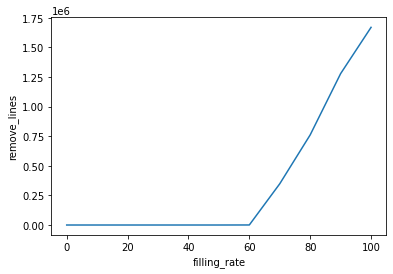

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_lines")

In [ ]:
find_rate =  previous_application.copy()
def filtration_line(dataframe, taux_remplissage):
    df = dataframe.copy()

    nb_lines = find_rate.shape[0]
    nb_columns = find_rate.shape[1]

    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of line at origin
    nb_lines = dataframe.shape[0]
                
    df['taux_remplissage_lines'] = (dataframe.apply(lambda x: x.count(), axis=1)/nb_columns)

    df_2 = df[df['taux_remplissage_lines'] > taux_remplissage]
  
            
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]

    print("Number of lines with a fill rate higher than {:.2%} : {} lines.".format(taux_remplissage, df_2.shape[0]))
    print("Number of lines deleted :",nb_lines_supp)
    print("Shape of data:",df_2.shape)
    
    del df_2['taux_remplissage_lines']

    return df_2

In [ ]:
previous_application = filtration_line(previous_application, 0.75)

Number of lines with a fill rate higher than 75.00% : 1075154 lines.
Number of lines deleted : 595060
Shape of data: (1075154, 38)


Suppression des colonnes qui ont un taux de remplissage inférieur à une limite

In [ ]:
find_rate = previous_application.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_colonne = find_rate.shape[1]

filling_rate = []
remove_col = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)

    df = find_rate[find_rate.columns[1-find_rate.isnull().mean() > taux_remplissage]]
    
    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]
    
    remove_col.append(nb_colonne_supp)
  
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_columns': remove_col
    })
find_rate

,filling_rate,remove_columns
0,0.0,0
1,10.0,3
2,20.0,3
3,30.0,3
4,40.0,3
5,50.0,3
6,60.0,3
7,70.0,6
8,80.0,8
9,90.0,10


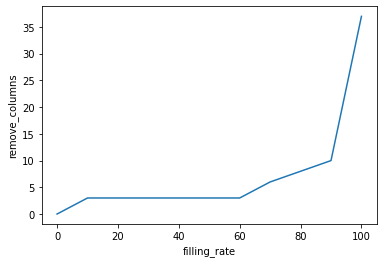

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_columns")

In [ ]:
def filtration_columns(dataframe, taux_remplissage):
    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of columns at origin
    nb_colonne = dataframe.shape[1]
    
    df = dataframe[dataframe.columns[1-dataframe.isnull().mean() > taux_remplissage]]

    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]

    print("Nombre de colonnes avec un taux de remplissage supérieur à {:.2%} : {} colonnes.".format(taux_remplissage, df.shape[1]))
    print("Nombre de colonnes supprimées : {} colonnes".format(nb_colonne_supp))

    return df

In [ ]:
previous_application = filtration_columns(previous_application, 0.9)

Nombre de colonnes avec un taux de remplissage supérieur à 90.00% : 27 colonnes.
Nombre de colonnes supprimées : 10 colonnes


In [ ]:
previous_application.shape

(1075154, 27)

In [ ]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,24835.5,FRIDAY,13,Y,1,XAP,Approved,-1740,Cash through the bank,XAP,Refreshed,Mobile,POS,XNA,Country-wide,23.0,Connectivity,8.0,high,POS mobile with interest,0.0
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,179055.0,SATURDAY,9,Y,1,XAP,Approved,-606,XNA,XAP,New,Vehicles,POS,XNA,Stone,500.0,Auto technology,24.0,low_normal,POS other with interest,0.0
1223745,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,68809.5,SATURDAY,15,Y,1,XAP,Approved,-2341,Cash through the bank,XAP,Refreshed,Consumer Electronics,POS,XNA,Country-wide,200.0,Consumer electronics,12.0,middle,POS household with interest,1.0
1021650,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,337500.0,SUNDAY,17,Y,1,XAP,Approved,-828,Cash through the bank,XAP,Refreshed,Furniture,POS,XNA,Stone,1400.0,Furniture,6.0,middle,POS industry with interest,0.0
575941,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,900000.0,FRIDAY,12,Y,1,XNA,Approved,-746,XNA,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,12.0,low_normal,Cash X-Sell: low,1.0


In [ ]:
previous_application_final = filling_nan_value(previous_application)

In [ ]:
features_obj =[feature for feature in previous_application.columns if previous_application[feature].dtypes=='O']
features_obj

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [ ]:
previous_application['NAME_CONTRACT_STATUS'].unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

In [ ]:
# Grouped interest rate into small medium and high of the previous application
previous_application['NAME_YIELD_GROUP'].unique()

array(['high', 'low_normal', 'middle', 'XNA', 'low_action'], dtype=object)

**Feature engineering**

In [ ]:
#label encoding the categorical variables
name_contract_dict = {'Approved': 0, 'Refused' : 3, 'Canceled' : 2, 'Unused offer' : 1}
previous_application['NAME_CONTRACT_STATUS'] = previous_application['NAME_CONTRACT_STATUS'].map(name_contract_dict)

yield_group_dict = {'XNA': 0, 'low_action': 1, 'low_normal': 2,'middle': 3, 'high': 4}
previous_application['NAME_YIELD_GROUP'] = previous_application['NAME_YIELD_GROUP'].map(yield_group_dict)

appl_per_contract_last_dict = {'Y':1, 'N':0}
previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = previous_application['FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)       

In [ ]:
# OneHotEncoder
remaining_categorical_columns = previous_application.dtypes[previous_application.dtypes == 'object'].index.tolist()
for col in remaining_categorical_columns:
    encoding_dict = dict([(j,i) for i,j in enumerate(previous_application[col].unique(),1)])
    previous_application[col] = previous_application[col].map(encoding_dict)  

In [ ]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,1,3951.000,24835.5,23787.0,24835.5,1,13,1,1,1,0,-1740,1,1,1,1,1,1,1,23.0,1,8.0,4,1,0.0
892077,1038818,100002,1,9251.775,179055.0,179055.0,179055.0,2,9,1,1,1,0,-606,2,1,2,2,1,1,2,500.0,2,24.0,2,2,0.0
1223745,2396755,100003,1,6737.310,68809.5,68053.5,68809.5,2,15,1,1,1,0,-2341,1,1,1,3,1,1,1,200.0,3,12.0,3,3,1.0
1021650,2636178,100003,1,64567.665,337500.0,348637.5,337500.0,3,17,1,1,1,0,-828,1,1,1,4,1,1,2,1400.0,4,6.0,3,4,0.0
575941,1810518,100003,2,98356.995,900000.0,1035882.0,900000.0,1,12,1,1,2,0,-746,2,1,3,5,2,2,3,-1.0,5,12.0,2,5,1.0


In [ ]:
#engineering some features on domain knowledge
# Ratio : montant de crédit demandé lors de la demande précédente \ Montant final du crédit sur la demande précédente
previous_application['AMT_CREDIT_APPLICATION_RATIO'] = previous_application['AMT_APPLICATION'] / (previous_application['AMT_CREDIT'] + 0.00001)

# Différence : montant de crédit demandé lors de la demande précédente - Montant final du crédit sur la demande précédente
previous_application['AMT_DECLINED'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']

previous_application['AMT_CREDIT_GOODS_RATIO'] = previous_application['AMT_CREDIT'] / (previous_application['AMT_GOODS_PRICE'] + 0.00001)

previous_application['AMT_CREDIT_GOODS_DIFF'] = previous_application['AMT_CREDIT'] - previous_application['AMT_GOODS_PRICE']

previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = previous_application['AMT_APPLICATION'] / (previous_application['DAYS_DECISION'] + 0.00001) * -1
previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = previous_application['AMT_APPLICATION'] / (previous_application['SELLERPLACE_AREA'] + 0.00001)
previous_application['ANNUITY'] = previous_application['AMT_CREDIT'] / (previous_application['CNT_PAYMENT'] + 0.00001)
previous_application['ANNUITY_GOODS'] = previous_application['AMT_GOODS_PRICE'] / (previous_application['CNT_PAYMENT'] + 0.00001)

previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = previous_application['AMT_CREDIT'] * previous_application['HOUR_APPR_PROCESS_START']
previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = previous_application['AMT_CREDIT'] * previous_application['NFLAG_LAST_APPL_IN_DAY']
previous_application['AMT_CREDIT_YIELD_GROUP'] = previous_application['AMT_CREDIT'] * previous_application['NAME_YIELD_GROUP']

#https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
previous_application['AMT_INTEREST'] = previous_application['CNT_PAYMENT'] * previous_application['AMT_ANNUITY'] - previous_application['AMT_CREDIT'] 
previous_application['INTEREST_SHARE'] = previous_application['AMT_INTEREST'] / (previous_application['AMT_CREDIT'] + 0.00001)
previous_application['INTEREST_RATE'] = 2 * 12 * previous_application['AMT_INTEREST'] / (previous_application['AMT_CREDIT'] * (previous_application['CNT_PAYMENT'] + 1))

In [ ]:
previous_application.to_csv("/content/drive/MyDrive/p7/data/previous_application_final.csv", index=False)


## **credit_card_balance.csv**

This table consists of the monthly data related to any or multiple Credit Cards that the applicant had with the Home Credit Group. The table contains fields like balance, the credit limit, amount of drawings, etc. for each month of the credit card.

In [ ]:
cc_balance.shape

(3840312, 23)

In [ ]:
 #there is one abruptly large value for AMT_PAYMENT_CURRENT
cc_balance['AMT_PAYMENT_CURRENT'][cc_balance['AMT_PAYMENT_CURRENT'] > 4000000] = np.nan

#making the MONTHS_BALANCE Positive
cc_balance['MONTHS_BALANCE'] = np.abs(cc_balance['MONTHS_BALANCE'])

#sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
cc_balance = cc_balance.sort_values(by = ['SK_ID_PREV','MONTHS_BALANCE'], ascending = [1,0])

In [ ]:
cc_balance.isnull().sum().sort_values(ascending= False).head(10)

AMT_PAYMENT_CURRENT           767989
AMT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_POS_CURRENT      749816
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
AMT_INST_MIN_REGULARITY       305236
SK_ID_PREV                         0
dtype: int64

Suppression des lignes qui ont un taux de remplissage inférieur à une limite

In [ ]:
find_rate =  cc_balance.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_lines = find_rate.shape[0]
nb_columns = find_rate.shape[1]
                
find_rate['taux_remplissage_lines'] = (cc_balance.apply(lambda x: x.count(), axis=1)/nb_columns)
    
filling_rate = []
remove_line = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)
    df_2 = find_rate[find_rate['taux_remplissage_lines'] > taux_remplissage]
              
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]
    remove_line.append(nb_lines_supp)
  
    del df_2['taux_remplissage_lines']
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_lines': remove_line})
find_rate

,filling_rate,remove_lines
0,0.0,0
1,10.0,0
2,20.0,0
3,30.0,0
4,40.0,0
5,50.0,0
6,60.0,0
7,70.0,741782
8,80.0,749816
9,90.0,761947


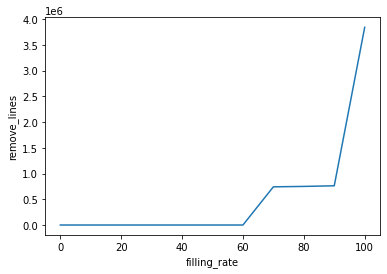

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_lines")

In [ ]:
find_rate =  cc_balance.copy()
def filtration_line(dataframe, taux_remplissage):
    df = dataframe.copy()

    nb_lines = find_rate.shape[0]
    nb_columns = find_rate.shape[1]

    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of line at origin
    nb_lines = dataframe.shape[0]
                
    df['taux_remplissage_lines'] = (dataframe.apply(lambda x: x.count(), axis=1)/nb_columns)

    df_2 = df[df['taux_remplissage_lines'] > taux_remplissage]
  
            
    #number of lines in the end
    nb_lines_supp = nb_lines - df_2.shape[0]

    print("Number of lines with a fill rate higher than {:.2%} : {} lines.".format(taux_remplissage, df_2.shape[0]))
    print("Number of lines deleted :",nb_lines_supp)
    print("Shape of data:",df_2.shape)
    
    del df_2['taux_remplissage_lines']

    return df_2

In [ ]:
cc_balance = filtration_line(cc_balance, 0.9)

Number of lines with a fill rate higher than 90.00% : 3078365 lines.
Number of lines deleted : 761947
Shape of data: (3078365, 24)


Suppression des colonnes qui ont un taux de remplissage inférieur à une limite

In [ ]:
find_rate = cc_balance.copy()
find_rate = find_rate.replace(to_replace = '^nan$', value = np.nan, regex=True)
nb_colonne = find_rate.shape[1]

filling_rate = []
remove_col = []

for i in range(0, 11, 1):
    taux_remplissage = i/10.0
    
    filling_rate.append(taux_remplissage*100)

    df = find_rate[find_rate.columns[1-find_rate.isnull().mean() > taux_remplissage]]
    
    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]
    
    remove_col.append(nb_colonne_supp)
  
    
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_columns': remove_col
    })
find_rate

,filling_rate,remove_columns
0,0.0,0
1,10.0,0
2,20.0,0
3,30.0,0
4,40.0,0
5,50.0,0
6,60.0,0
7,70.0,0
8,80.0,0
9,90.0,0


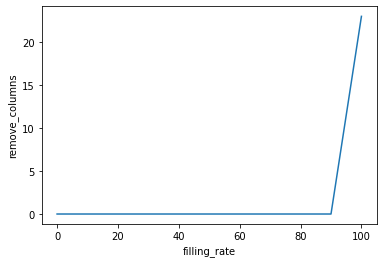

In [ ]:
sns.lineplot(data=find_rate, x="filling_rate", y="remove_columns")

In [ ]:
def filtration_columns(dataframe, taux_remplissage):
    dataframe = dataframe.replace(to_replace = '^nan$', value = np.nan, regex=True)
    #number of columns at origin
    nb_colonne = dataframe.shape[1]
    
    df = dataframe[dataframe.columns[1-dataframe.isnull().mean() > taux_remplissage]]

    #number of columns at the end
    nb_colonne_supp = nb_colonne - df.shape[1]

    print("Nombre de colonnes avec un taux de remplissage supérieur à {:.2%} : {} colonnes.".format(taux_remplissage, df.shape[1]))
    print("Nombre de colonnes supprimées : {} colonnes".format(nb_colonne_supp))

    return df

In [ ]:
cc_balance = filtration_columns(cc_balance, 0.8)

Nombre de colonnes avec un taux de remplissage supérieur à 80.00% : 23 colonnes.
Nombre de colonnes supprimées : 0 colonnes


In [ ]:
cc_balance.shape

(3078365, 23)

In [ ]:
# filling nan
cc_balance = filling_nan_value(cc_balance)

In [ ]:
#Creating new features
cc_balance['AMT_DRAWING_SUM'] = cc_balance['AMT_DRAWINGS_ATM_CURRENT'] + cc_balance['AMT_DRAWINGS_CURRENT'] + cc_balance[
                            'AMT_DRAWINGS_OTHER_CURRENT'] + cc_balance['AMT_DRAWINGS_POS_CURRENT']

cc_balance['BALANCE_LIMIT_RATIO'] = cc_balance['AMT_BALANCE'] / (cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
cc_balance['CNT_DRAWING_SUM'] = cc_balance['CNT_DRAWINGS_ATM_CURRENT'] + cc_balance['CNT_DRAWINGS_CURRENT'] + cc_balance[
                                    'CNT_DRAWINGS_OTHER_CURRENT'] + cc_balance['CNT_DRAWINGS_POS_CURRENT'] + cc_balance['CNT_INSTALMENT_MATURE_CUM']
cc_balance['MIN_PAYMENT_RATIO'] = cc_balance['AMT_PAYMENT_CURRENT'] / (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_CURRENT'] - cc_balance['AMT_INST_MIN_REGULARITY']
cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (cc_balance['AMT_INST_MIN_REGULARITY'] +0.00001)
cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - cc_balance['AMT_INST_MIN_REGULARITY']
cc_balance['AMT_INTEREST_RECEIVABLE'] = cc_balance['AMT_TOTAL_RECEIVABLE'] - cc_balance['AMT_RECEIVABLE_PRINCIPAL']
cc_balance['SK_DPD_RATIO'] = cc_balance['SK_DPD'] / (cc_balance['SK_DPD_DEF'] + 0.00001)

In [ ]:
#calculating the rolling Exponential Weighted Moving Average over months for certain features
rolling_columns = [ 'AMT_BALANCE',
                    'AMT_CREDIT_LIMIT_ACTUAL',
                    'AMT_RECEIVABLE_PRINCIPAL',
                    'AMT_RECIVABLE',
                    'AMT_TOTAL_RECEIVABLE',
                    'AMT_DRAWING_SUM',
                    'BALANCE_LIMIT_RATIO',
                    'CNT_DRAWING_SUM',
                    'MIN_PAYMENT_RATIO',
                    'PAYMENT_MIN_DIFF',
                    'MIN_PAYMENT_TOTAL_RATIO',
                    'AMT_INTEREST_RECEIVABLE',
                    'SK_DPD_RATIO' ]
exp_weighted_columns = ['EXP_' + ele for ele in rolling_columns]
cc_balance[exp_weighted_columns] = cc_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])[rolling_columns].transform(lambda x: x.ewm(alpha = 0.7).mean())
        

In [ ]:
#performing aggregations over SK_ID_PREV
overall_aggregations = {'SK_ID_CURR' : ['first'],
                        'MONTHS_BALANCE': ['max'],
                        'AMT_BALANCE' : ['sum','mean','max'],
                        'AMT_CREDIT_LIMIT_ACTUAL' : ['sum','mean','max'],
                        'AMT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
                        'AMT_DRAWINGS_CURRENT' : ['sum','max'],
                        'AMT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
                        'AMT_DRAWINGS_POS_CURRENT' : ['sum','max'],
                        'AMT_INST_MIN_REGULARITY' : ['mean','min','max'],
                        'AMT_PAYMENT_CURRENT' : ['mean','min','max'],
                        'AMT_PAYMENT_TOTAL_CURRENT' : ['mean','min','max'],
                        'AMT_RECEIVABLE_PRINCIPAL' : ['sum','mean','max'],
                        'AMT_RECIVABLE' : ['sum','mean','max'],
                        'AMT_TOTAL_RECEIVABLE' : ['sum','mean','max'],
                        'CNT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
                        'CNT_DRAWINGS_CURRENT' : ['sum','max'],
                        'CNT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
                        'CNT_DRAWINGS_POS_CURRENT' : ['sum','max'],
                        'CNT_INSTALMENT_MATURE_CUM' : ['sum','max','min'],
                        'SK_DPD' : ['sum','max'],
                        'SK_DPD_DEF' : ['sum','max'],

                        'AMT_DRAWING_SUM' : ['sum','max'],
                        'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
                        'CNT_DRAWING_SUM' : ['sum','max'],
                        'MIN_PAYMENT_RATIO': ['min','mean'],
                        'PAYMENT_MIN_DIFF' : ['min','mean'],
                        'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
                        'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
                        'SK_DPD_RATIO' : ['max','mean'],

                        'EXP_AMT_BALANCE' : ['last'],
                        'EXP_AMT_CREDIT_LIMIT_ACTUAL' : ['last'],
                        'EXP_AMT_RECEIVABLE_PRINCIPAL' : ['last'],
                        'EXP_AMT_RECIVABLE' : ['last'],
                        'EXP_AMT_TOTAL_RECEIVABLE' : ['last'],
                        'EXP_AMT_DRAWING_SUM' : ['last'],
                        'EXP_BALANCE_LIMIT_RATIO' : ['last'],
                        'EXP_CNT_DRAWING_SUM' : ['last'],
                        'EXP_MIN_PAYMENT_RATIO' : ['last'],
                        'EXP_PAYMENT_MIN_DIFF' : ['last'],
                        'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
                        'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
                        'EXP_SK_DPD_RATIO' : ['last'], }
                        
aggregations_for_categories = {
                        'SK_DPD' : ['sum','max'],
                        'SK_DPD_DEF' : ['sum','max'],
                        'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
                        'CNT_DRAWING_SUM' : ['sum','max'],
                        'MIN_PAYMENT_RATIO': ['min','mean'],
                        'PAYMENT_MIN_DIFF' : ['min','mean'],
                        'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
                        'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
                        'SK_DPD_RATIO' : ['max','mean'],
                        'EXP_AMT_DRAWING_SUM' : ['last'],
                        'EXP_BALANCE_LIMIT_RATIO' : ['last'],
                        'EXP_CNT_DRAWING_SUM' : ['last'],
                        'EXP_MIN_PAYMENT_RATIO' : ['last'],
                        'EXP_PAYMENT_MIN_DIFF' : ['last'],
                        'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
                        'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
                        'EXP_SK_DPD_RATIO' : ['last']
                    }
aggregations_for_year = {
                        'SK_DPD' : ['sum','max'],
                        'SK_DPD_DEF' : ['sum','max'],
                        'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
                        'CNT_DRAWING_SUM' : ['sum','max'],
                        'MIN_PAYMENT_RATIO': ['min','mean'],
                        'PAYMENT_MIN_DIFF' : ['min','mean'],
                        'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
                        'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
                        'SK_DPD_RATIO' : ['max','mean'],
                        'EXP_AMT_DRAWING_SUM' : ['last'],
                        'EXP_BALANCE_LIMIT_RATIO' : ['last'],
                        'EXP_CNT_DRAWING_SUM' : ['last'],
                        'EXP_MIN_PAYMENT_RATIO' : ['last'],
                        'EXP_PAYMENT_MIN_DIFF' : ['last'],
                        'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
                        'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
                        'EXP_SK_DPD_RATIO' : ['last']
                    }
#performing overall aggregations over SK_ID_PREV for all features
cc_balance_aggregated_overall = cc_balance.groupby('SK_ID_PREV').agg(overall_aggregations)
cc_balance_aggregated_overall.columns = ['_'.join(ele).upper() for ele in cc_balance_aggregated_overall.columns]
cc_balance_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST' : 'SK_ID_CURR'}, inplace = True)


In [ ]:
#aggregating over SK_ID_PREV for different categories
contract_status_categories = ['Active','Completed']
cc_balance_aggregated_categories = pd.DataFrame()
for i, contract_type in enumerate(contract_status_categories):
    group = cc_balance[cc_balance['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
    group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
    if i == 0:
        cc_balance_aggregated_categories = group
    else:
        cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(group, on = 'SK_ID_PREV', how = 'outer')
#aggregating over SK_ID_PREV for rest of the categories
cc_balance_aggregated_categories_rest = cc_balance[(cc_balance['NAME_CONTRACT_STATUS'] != 'Active') & 
                                (cc_balance.NAME_CONTRACT_STATUS != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
cc_balance_aggregated_categories_rest.columns = ['_'.join(ele).upper() + '_REST' for ele in cc_balance_aggregated_categories_rest.columns]
#merging all the categorical aggregations
cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(cc_balance_aggregated_categories_rest, on = 'SK_ID_PREV', how = 'outer')

#aggregating over SK_ID_PREV for different years
cc_balance['YEAR_BALANCE'] = cc_balance['MONTHS_BALANCE'] //12
cc_balance_aggregated_year = pd.DataFrame()
for year in range(2):
    group = cc_balance[cc_balance['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
    group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
    if year == 0:
        cc_balance_aggregated_year = group
    else:
        cc_balance_aggregated_year = cc_balance_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')
#aggregating over SK_ID_PREV for rest of years
cc_balance_aggregated_year_rest = cc_balance[cc_balance['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
cc_balance_aggregated_year_rest.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in cc_balance_aggregated_year_rest.columns]
#merging all the yearwise aggregations
cc_balance_aggregated_year = cc_balance_aggregated_year.merge(cc_balance_aggregated_year_rest, on = 'SK_ID_PREV', how = 'outer')
cc_balance = cc_balance.drop('YEAR_BALANCE', axis = 1)


In [ ]:

#merging all the aggregations
cc_aggregated = cc_balance_aggregated_overall.merge(cc_balance_aggregated_categories, on = 'SK_ID_PREV', how = 'outer')
cc_aggregated = cc_aggregated.merge(cc_balance_aggregated_year, on = 'SK_ID_PREV', how = 'outer')


In [ ]:
cc_aggregated.to_csv("/content/drive/MyDrive/p7/data/cc_aggregated.csv", index=False)

## **installments_payments.csv**

This table contains the details about each installment of client's previous credits with Home Credit Group.

We start by sorting the data first by SK_ID_CURR and SK_ID_PREV, and then by NUM_INSTALMENT_NUMBER. This brings the latest installments in the end.
We create some features, such as the number of days the payment was delayed, the difference in amount of payment required vs paid, etc.
Next we aggregate these rows over SK_ID_PREV, such that each client's previous loan gets one row. These aggregations are done in three ways, first overall aggregations, second we aggregate only those installments which were in the last 365 days, and lastly, we aggregate the first 5 installments of every loan. This will help us to capture the starting behaviour, the latest behaviour and the overall behaviour of the client's installments payments.
Now to merge this table with main table, we aggregate the data over SK_ID_CURR.

In [ ]:
install_pay.shape

(13605401, 8)

In [ ]:
install_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
install_pay.isnull().sum().sort_values(ascending= False).head(5)

DAYS_ENTRY_PAYMENT        2905
AMT_PAYMENT               2905
SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
dtype: int64

In [ ]:
# filling NAN
installments_payments = filling_nan_value(install_pay)

In [ ]:
#engineering new features based on some domain based polynomial operations
installments_payments['DAYS_PAYMENT_RATIO'] = installments_payments['DAYS_INSTALMENT'] / (installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
installments_payments['DAYS_PAYMENT_DIFF'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['AMT_PAYMENT_RATIO'] = installments_payments['AMT_PAYMENT'] / (installments_payments['AMT_INSTALMENT'] + 0.00001)
installments_payments['AMT_PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
installments_payments['EXP_DAYS_PAYMENT_RATIO'] = installments_payments['DAYS_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
installments_payments['EXP_DAYS_PAYMENT_DIFF'] = installments_payments['DAYS_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
installments_payments['EXP_AMT_PAYMENT_RATIO'] = installments_payments['AMT_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
installments_payments['EXP_AMT_PAYMENT_DIFF'] = installments_payments['AMT_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
     

In [ ]:
#aggregating the data over SK_ID_PREV, i.e. for each previous loan
overall_aggregations = {
                        'NUM_INSTALMENT_VERSION' : ['mean','sum'],
                        'NUM_INSTALMENT_NUMBER' : ['max'],
                        'DAYS_INSTALMENT' : ['max','min'],
                        'DAYS_ENTRY_PAYMENT' : ['max','min'],
                        'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
                        'AMT_PAYMENT' : ['mean', 'sum', 'max'],
                        'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
                        'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
                        'AMT_PAYMENT_RATIO' : ['mean','min','max'],
                        'AMT_PAYMENT_DIFF' : ['mean','min','max'],
                        'EXP_DAYS_PAYMENT_RATIO' : ['last'],
                        'EXP_DAYS_PAYMENT_DIFF' : ['last'],
                        'EXP_AMT_PAYMENT_RATIO' : ['last'],
                        'EXP_AMT_PAYMENT_DIFF' : ['last']
}
limited_period_aggregations = {
                                'NUM_INSTALMENT_VERSION' : ['mean','sum'],
                                'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
                                'AMT_PAYMENT' : ['mean', 'sum', 'max'],
                                'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
                                'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
                                'AMT_PAYMENT_RATIO' : ['mean','min','max'],
                                'AMT_PAYMENT_DIFF' : ['mean','min','max'],
                                'EXP_DAYS_PAYMENT_RATIO' : ['last'],
                                'EXP_DAYS_PAYMENT_DIFF' : ['last'],
                                'EXP_AMT_PAYMENT_RATIO' : ['last'],
                                'EXP_AMT_PAYMENT_DIFF' : ['last']
}
#aggregating installments_payments over SK_ID_PREV for last 1 year installments
group_last_1_year = installments_payments[installments_payments['DAYS_INSTALMENT'] > -365].groupby('SK_ID_PREV').agg(limited_period_aggregations)
group_last_1_year.columns = ['_'.join(ele).upper() + '_LAST_1_YEAR' for ele in group_last_1_year.columns]

#aggregating installments_payments over SK_ID_PREV for first 5 installments
group_first_5_instalments = installments_payments.groupby('SK_ID_PREV', as_index = False).head(5).groupby('SK_ID_PREV').agg(limited_period_aggregations)
group_first_5_instalments.columns = ['_'.join(ele).upper() + '_FIRST_5_INSTALLMENTS' for ele in group_first_5_instalments.columns]

#overall aggregation of installments_payments over SK_ID_PREV
group_overall = installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False).agg(overall_aggregations)
group_overall.columns = ['_'.join(ele).upper() for ele in group_overall.columns]
group_overall.rename(columns = {'SK_ID_PREV_': 'SK_ID_PREV','SK_ID_CURR_' : 'SK_ID_CURR'}, inplace = True)

#merging all of the above aggregations together
installments_payments_agg_prev = group_overall.merge(group_last_1_year, on = 'SK_ID_PREV', how = 'outer')
installments_payments_agg_prev = installments_payments_agg_prev.merge(group_first_5_instalments, on = 'SK_ID_PREV', how = 'outer')

In [ ]:
#aggregating over SK_ID_CURR
main_features_aggregations = {
                                'NUM_INSTALMENT_VERSION_MEAN' : ['mean'],
                                'NUM_INSTALMENT_VERSION_SUM' : ['mean'],
                                'NUM_INSTALMENT_NUMBER_MAX' : ['mean','sum','max'],
                                'AMT_INSTALMENT_MEAN' : ['mean','sum','max'],
                                'AMT_INSTALMENT_SUM' : ['mean','sum','max'],
                                'AMT_INSTALMENT_MAX' : ['mean'],
                                'AMT_PAYMENT_MEAN' : ['mean','sum','max'],
                                'AMT_PAYMENT_SUM' : ['mean','sum','max'],
                                'AMT_PAYMENT_MAX' : ['mean'],
                                'DAYS_PAYMENT_RATIO_MEAN' : ['mean','min','max'],
                                'DAYS_PAYMENT_RATIO_MIN' : ['mean','min'],
                                'DAYS_PAYMENT_RATIO_MAX' : ['mean','max'],
                                'DAYS_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
                                'DAYS_PAYMENT_DIFF_MIN' : ['mean','min'],
                                'DAYS_PAYMENT_DIFF_MAX' : ['mean','max'],
                                'AMT_PAYMENT_RATIO_MEAN' : ['mean', 'min','max'],
                                'AMT_PAYMENT_RATIO_MIN' : ['mean','min'],
                                'AMT_PAYMENT_RATIO_MAX' : ['mean','max'],
                                'AMT_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
                                'AMT_PAYMENT_DIFF_MIN' : ['mean','min'],
                                'AMT_PAYMENT_DIFF_MAX' : ['mean','max'],
                                'EXP_DAYS_PAYMENT_RATIO_LAST' : ['mean'],
                                'EXP_DAYS_PAYMENT_DIFF_LAST' : ['mean'],
                                'EXP_AMT_PAYMENT_RATIO_LAST' : ['mean'],
                                'EXP_AMT_PAYMENT_DIFF_LAST' : ['mean'] }

grouped_main_features = installments_payments_agg_prev.groupby('SK_ID_CURR').agg(main_features_aggregations)
grouped_main_features.columns = ['_'.join(ele).upper() for ele in grouped_main_features.columns]

#group remaining ones
grouped_remaining_features = installments_payments_agg_prev.iloc[:,[1] + list(range(31,len(installments_payments_agg_prev.columns)))].groupby('SK_ID_CURR').mean()

installments_payments_aggregated = grouped_main_features.merge(grouped_remaining_features, on = 'SK_ID_CURR', how = 'inner')

In [ ]:
installments_payments_aggregated.to_csv("/content/drive/MyDrive/p7/data/installments_payments_aggregated.csv", index=False)

## **POS_CASH_balance.csv**

This table contains the Monthly Balance Snapshots of previous Point of Sales and Cash Loans that the applicant had with Home Credit Group. The table contains columns like the status of contract, the number of installments left, etc.

Similar to bureau_balance table, this table also has time based features. So we start off by computing the EDAs on CNT_INSTALMENT and CNT_INSTALMENT_FUTURE features.
We create some domain based features next.
We then aggregate the data over SK_ID_PREV. For this aggregation, we do it in 3 ways. Firstly we aggregate the whole data over SK_ID_PREV. We also aggregate the data for last 2 years separately and rest of the years separately. Finally, we also aggregate the data different Contract types, i.e. Active and Completed.
Next, we aggregate the data over SK_ID_CURR, for it to be merged with main table.

In [ ]:
pos_cash_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
pos_cash_bal.shape

(10001358, 8)

In [ ]:
pos_cash_bal.isnull().sum().sort_values(ascending= False).head(10)

CNT_INSTALMENT_FUTURE    26087
CNT_INSTALMENT           26071
SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [ ]:
# filling NAN
installments_payments = filling_nan_value(install_pay)

In [ ]:
pos_cash= pos_cash_bal.copy()

In [ ]:
#making the MONTHS_BALANCE Positive
pos_cash['MONTHS_BALANCE'] = np.abs(pos_cash['MONTHS_BALANCE'])
#sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
pos_cash = pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)


In [ ]:
#creating new features based on Domain Knowledge
pos_cash['SK_DPD_RATIO'] = pos_cash['SK_DPD'] / (pos_cash['SK_DPD_DEF'] + 0.00001)
pos_cash['TOTAL_TERM'] = pos_cash['CNT_INSTALMENT'] + pos_cash['CNT_INSTALMENT_FUTURE']

In [ ]:
pos_cash.isnull().sum().sort_values(ascending= False).head(10)

TOTAL_TERM               26184
CNT_INSTALMENT_FUTURE    26087
CNT_INSTALMENT           26071
SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
SK_DPD_RATIO                 0
dtype: int64

In [ ]:
 #aggregating over SK_ID_PREV
dico_agg_pos = {'MONTHS_BALANCE' : ['max'],
                'CNT_INSTALMENT' : ['mean', 'max','min'],
                'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
                'SK_DPD' : ['max','sum'],
                'SK_DPD_DEF' : ['max','sum'],

                'SK_DPD_RATIO' : ['mean','max'],
                'TOTAL_TERM' : ['mean','max','last'],}

In [ ]:
def agg_var_num(dataframe, group_var, dict_agg, prefix):
    """
    Aggregates the numeric values in a dataframe.
    This can be used to create features for each instance of the grouping variable.
    Parameters
    --------
        dataframe (dataframe): the dataframe to calculate the statistics on
        group_var (string): the variable by which to group df
        df_name (string): the variable used to rename the columns
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            some statistics (mean, min, max, sum ...) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in dataframe:
        if col != group_var and 'SK_ID' in col:
            dataframe = dataframe.drop(columns=col)

    group_ids = dataframe[group_var]
    numeric_df = dataframe.select_dtypes('number')
    numeric_df[group_var] = group_ids
        # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(dict_agg)

    # Ajout suffix mean, sum...
    agg.columns = ['_'.join(tup).strip().upper()
                   for tup in agg.columns.values]

    # Ajout du prefix bureau_balance pour avoir une idée du fichier
    agg.columns = [prefix + '_' + col
                   if col != group_var else col
                   for col in agg.columns]

    agg.reset_index(inplace=True)

    return agg

In [ ]:
# --------------------------------------------------------------------
# -- AGGREGATION DES VARIABLES STATISTIQUES des VAR QUALITATIVES
# --------------------------------------------------------------------
def agg_var_cat(dataframe, group_var, prefix):
    '''
        Aggregates the categorical features in a child dataframe
        for each observation of the parent variable.
        
        Parameters
        --------
        - dataframe        : pandas dataframe
                    The dataframe to calculate the value counts for.
            
        - parent_var : string
                    The variable by which to group and aggregate 
                    the dataframe. For each unique value of this variable, 
                    the final dataframe will have one row
            
        - prefix    : string
                    Variable added to the front of column names 
                    to keep track of columns
        Return
        --------
        
        categorical : pandas dataframe
                    A dataframe with aggregated statistics for each observation 
                    of the parent_var
                    The columns are also renamed and columns with duplicate values 
                    are removed.
                        '''
    
    # Select the categorical columns
    categorical = pd.get_dummies(dataframe.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = dataframe[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (prefix, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
        # _, idx = np.unique(categorical, axis = 1, return_index = True)
    # categorical = categorical.iloc[:, idx]
    
    return categorical

In [ ]:
agg_pos_num = agg_var_num(pos_cash.drop(columns=['SK_ID_PREV']),'SK_ID_CURR', dico_agg_pos, 'POS_CASH')

In [ ]:
agg_pos_cat = agg_var_cat(pos_cash,'SK_ID_CURR', 'POS_CASH')

In [ ]:
agg_pos_cat.shape

(337252, 27)

In [ ]:
agg_pos_num.shape

(337252, 17)

In [ ]:
agg_pos_final = agg_pos_cat.merge(agg_pos_num, on = 'SK_ID_CURR', how = 'left')

In [ ]:
agg_pos_final.shape

(337252, 44)

In [ ]:
agg_pos_final.head(5)

,SK_ID_CURR,POS_CASH_NAME_CONTRACT_STATUS_Active_sum,POS_CASH_NAME_CONTRACT_STATUS_Active_count,POS_CASH_NAME_CONTRACT_STATUS_Active_mean,POS_CASH_NAME_CONTRACT_STATUS_Amortized debt_sum,POS_CASH_NAME_CONTRACT_STATUS_Amortized debt_count,POS_CASH_NAME_CONTRACT_STATUS_Amortized debt_mean,POS_CASH_NAME_CONTRACT_STATUS_Approved_sum,POS_CASH_NAME_CONTRACT_STATUS_Approved_count,POS_CASH_NAME_CONTRACT_STATUS_Approved_mean,POS_CASH_NAME_CONTRACT_STATUS_Canceled_sum,POS_CASH_NAME_CONTRACT_STATUS_Canceled_count,POS_CASH_NAME_CONTRACT_STATUS_Canceled_mean,POS_CASH_NAME_CONTRACT_STATUS_Completed_sum,POS_CASH_NAME_CONTRACT_STATUS_Completed_count,POS_CASH_NAME_CONTRACT_STATUS_Completed_mean,POS_CASH_NAME_CONTRACT_STATUS_Demand_sum,POS_CASH_NAME_CONTRACT_STATUS_Demand_count,POS_CASH_NAME_CONTRACT_STATUS_Demand_mean,POS_CASH_NAME_CONTRACT_STATUS_Returned to the store_sum,POS_CASH_NAME_CONTRACT_STATUS_Returned to the store_count,POS_CASH_NAME_CONTRACT_STATUS_Returned to the store_mean,POS_CASH_NAME_CONTRACT_STATUS_Signed_sum,POS_CASH_NAME_CONTRACT_STATUS_Signed_count,POS_CASH_NAME_CONTRACT_STATUS_Signed_mean,POS_CASH_NAME_CONTRACT_STATUS_XNA_sum,POS_CASH_NAME_CONTRACT_STATUS_XNA_count,POS_CASH_NAME_CONTRACT_STATUS_XNA_mean,POS_CASH_MONTHS_BALANCE_MAX,POS_CASH_CNT_INSTALMENT_MEAN,POS_CASH_CNT_INSTALMENT_MAX,POS_CASH_CNT_INSTALMENT_MIN,POS_CASH_CNT_INSTALMENT_FUTURE_MEAN,POS_CASH_CNT_INSTALMENT_FUTURE_MAX,POS_CASH_CNT_INSTALMENT_FUTURE_MIN,POS_CASH_SK_DPD_MAX,POS_CASH_SK_DPD_SUM,POS_CASH_SK_DPD_DEF_MAX,POS_CASH_SK_DPD_DEF_SUM,POS_CASH_SK_DPD_RATIO_MEAN,POS_CASH_SK_DPD_RATIO_MAX,POS_CASH_TOTAL_TERM_MEAN,POS_CASH_TOTAL_TERM_MAX,POS_CASH_TOTAL_TERM_LAST
0,100001,7.0,9,0.777778,0,9,0.0,0,9,0.0,0,9,0.0,2,9,0.222222,0,9,0.0,0,9,0.0,0,9,0.000000,0,9,0.0,96,4.000000,4.0,4.0,1.444444,4.0,0.0,7,7,7,7,0.111111,0.999999,5.444444,8.0,4.0
1,100002,19.0,19,1.000000,0,19,0.0,0,19,0.0,0,19,0.0,0,19,0.000000,0,19,0.0,0,19,0.0,0,19,0.000000,0,19,0.0,19,24.000000,24.0,24.0,15.000000,24.0,6.0,0,0,0,0,0.000000,0.000000,39.000000,48.0,30.0
2,100003,26.0,28,0.928571,0,28,0.0,0,28,0.0,0,28,0.0,2,28,0.071429,0,28,0.0,0,28,0.0,0,28,0.000000,0,28,0.0,77,10.107143,12.0,6.0,5.785714,12.0,0.0,0,0,0,0,0.000000,0.000000,15.892857,24.0,7.0
3,100004,3.0,4,0.750000,0,4,0.0,0,4,0.0,0,4,0.0,1,4,0.250000,0,4,0.0,0,4,0.0,0,4,0.000000,0,4,0.0,27,3.750000,4.0,3.0,2.250000,4.0,0.0,0,0,0,0,0.000000,0.000000,6.000000,8.0,3.0
4,100005,9.0,11,0.818182,0,11,0.0,0,11,0.0,0,11,0.0,1,11,0.090909,0,11,0.0,0,11,0.0,1,11,0.090909,0,11,0.0,25,11.700000,12.0,9.0,7.200000,12.0,0.0,0,0,0,0,0.000000,0.000000,18.900000,24.0,9.0


In [ ]:
agg_pos_final.to_csv("/content/drive/MyDrive/p7/data/agg_pos_final.csv", index=False)

## $\color{red}{\text{T.B.C}}$

## **Merging All Tables**


Now we will merge all the preprocessed tables with the application_train and application_test tables. The merges will be Left Outer Joins, such that all the current applications are preserved, as we have to model on them.

In [ ]:
#merging application_train and application_test with Aggregated bureau table
app_train_merged = application_train.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
app_test_merged = application_test.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')

#merging with aggregated previous_applications
app_train_merged = app_train_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
app_test_merged = app_test_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')

#merging with aggregated installments tables
app_train_merged = app_train_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
app_test_merged = app_test_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')

#merging with aggregated POS_Cash balance table
app_train_merged = app_train_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
app_test_merged = app_test_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')

#merging with aggregated credit card table
app_train_merged = app_train_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')
app_test_merged = app_test_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')

In [ ]:
app_train_merged.to_csv("/content/drive/MyDrive/p7/data/app_train_merged.csv", index=False)
app_test_merged.to_csv("/content/drive/MyDrive/p7/data/app_test_merged.csv", index=False)

## **Feature Selection using LightGBM**

https://medium.com/@indreshbhattacharyya/feature-selection-categorical-featur

In [ ]:
#Download final databases
test_set= pd.read_csv('/content/drive/MyDrive/p7/data/app_train_merged.csv')
train_set= pd.read_csv('/content/drive/MyDrive/p7/data/app_test_merged.csv',low_memory=False)

**Looking for empty features**

Here, empty features refer to those features which have just one unique value. These features are useless for the classifiers, as they do not contain any information.

In [ ]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis = 1)
test_data = test_data.drop(empty_columns, axis = 1)

In [ ]:
import lightgbm as lgb

In [ ]:
def description_variables(dataframe, type_var='all'):
    """
    Retourne la description des variables qualitatives/quantitatives
    ou toutes les variables du dataframe transmis :
    type, nombre de nan, % de nan et desc
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                type_var = 'all' ==> tous les types de variables (défaut)
                           'cat' ==> variables catégorielles
                           'num' ==> variables quantitative
                           facultatif
    @param OUT : dataframe de description des variables
    """
    df_taille = dataframe.shape[0]

    if type_var == 'num':
        desc_var = dataframe.describe(datetime_is_numeric=True)
    elif type_var == 'cat':
        desc_var = dataframe.describe(
            exclude=[np.number], datetime_is_numeric=True)
    else:
        desc_var = dataframe.describe(include='all', datetime_is_numeric=True)

    desc_type = pd.DataFrame(
        dataframe[desc_var.columns].dtypes, columns=['type']).T
    nb_nan = df_taille - desc_var.loc['count'].T
    pourcentage_nan = nb_nan * 100 / np.product(dataframe.shape)
    desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                            index=['nb_nan', '%_nan'])
    desc_var = pd.concat([desc_type, desc_nan, desc_var])

    return desc_var

In [ ]:
desc_train_set = description_variables(train_set)

In [ ]:
desc_train_set.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,EXT_SOURCE_1,CREDIT_INCOME_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,CREDIT_EXT_RATIO,EMPLOYED_TO_AGE_RATIO,CHILDREN_INCOME_RATIO,PER_CAPITA_INCOME,DAYS_DETAILS_CHANGE_MUL,DAYS_DETAILS_CHANGE_SUM
type,int64,int64,object,object,object,object,int64,float64,float64,float64,float64,object,object,object,object,object,float64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,object,float64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,object,...,float64,object,object,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nb_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,175034.0,175034.0,175034,175034,175034,175034,175034.0,175034.0,175034.0,175034.0,175034.0,175034,175034,175034,175034,175034,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034,175034.0,175034.0,175034.0,175034,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034,...,175034.0,175034,175034,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0,175034.0
unique,NaN,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,...,NaN,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_set.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,EXT_SOURCE_1,CREDIT_INCOME_RATIO,ANNUITY_CREDIT_RATIO,ANNUITY_INCOME_RATIO,CREDIT_EXT_RATIO,EMPLOYED_TO_AGE_RATIO,CHILDREN_INCOME_RATIO,PER_CAPITA_INCOME,DAYS_DETAILS_CHANGE_MUL,DAYS_DETAILS_CHANGE_SUM
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,...,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25.920548,0.083037,2.007889,0.060749,0.121978,2.917275e+06,0.067329,0.000000,101250.0,-8.770084e+09,-6902.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,...,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45.931507,0.311267,4.790750,0.027598,0.132217,2.416514e+06,0.070862,0.000000,90000.0,-2.857643e+08,-2305.0
2,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130.0,-1213.0,-619,1,1,0,1,1,0,Accountants,3.0,2,2,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,...,0.0688,Panel,No,1.0,0.0,1.0,0.0,-1562.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,37.747945,0.774761,9.127053,0.026463,0.241526,3.171820e+06,0.227174,0.000006,42750.0,-1.172823e+09,-3394.0
3,100016,0,Cash loans,F,N,Y,0,67500.0,80865.0,5881.5,67500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.031329,-13439,-2717.0,-311.0,-3227,1,1,1,1,1,0,Laborers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Business Entity Type 2,...,0.0612,Panel,No,0.0,0.0,0.0,0.0,-2370.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,36.819178,0.464831,1.198000,0.072732,0.087133,4.577629e+05,0.202173,0.000000,22500.0,-2.378525e+09,-5908.0
4,100017,0,Cash loans,M,Y,N,1,225000.0,918468.0,28966.5,697500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.016612,-14086,-3028.0,-643.0,-4911,1,1,0,1,0,0,Drivers,3.0,2,2,THURSDAY,13,0,0,0,0,0,0,Self-employed,...,0.1417,Panel,No,0.0,0.0,0.0,0.0,-4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,38.591781,0.514184,4.082080,0.031538,0.128740,1.192681e+06,0.214965,0.000004,56250.0,-1.263109e+07,-5558.0


In [ ]:
train_set.isnull().sort_values(ascending =False, by=).sum()

TypeError: ignored

In [ ]:
# Résumé des variables qualitatives
desc_train_set = outils_data.description_variables(train_set)
desc_train_set

In [ ]:
# Dataframes de travail
train_sans_fs_lgbm = train_set.copy()
train_sans_fs_lgbm = train_sans_fs_lgbm.drop(['TARGET_NEIGHBORS_500_MEAN'],
                                             axis=1)
print(f'train_sans_fs_lgbm : {train_sans_fs_lgbm.shape}')
test_sans_fs_lgbm = test_set.copy()
test_sans_fs_lgbm = test_sans_fs_lgbm.drop(['TARGET_NEIGHBORS_500_MEAN'],
                                           axis=1)
print(f'test_sans_fs_lgbm : {test_sans_fs_lgbm.shape}')

In [ ]:
# Sauvegarde des étiquettes car l'alignement supprimera
# cette variable.
train_sans_fs_lgbm_labels = train_sans_fs_lgbm['TARGET']

# Sauvegarde des identifiants
train_sans_fs_lgbm_ids = train_sans_fs_lgbm['SK_ID_CURR']
test_sans_fs_lgbm_ids = test_sans_fs_lgbm['SK_ID_CURR']

# Alignement des dataframes (suppression variable TARGET)
train_sans_fs_lgbm, test_sans_fs_lgbm = \
    train_sans_fs_lgbm.align(test_sans_fs_lgbm, join='inner', axis=1)

# Suppression des identifiants (variable non utile pour les variables
# pertinentes)
train_sans_fs_lgbm = train_sans_fs_lgbm.drop(columns=['SK_ID_CURR'])
test_sans_fs_lgbm = test_sans_fs_lgbm.drop(columns=['SK_ID_CURR'])

print(f'train_fs_lgbm : {train_sans_fs_lgbm.shape}')
print(f'test_fs_lgbm : {test_sans_fs_lgbm.shape}')

In [ ]:
# Initialiser un tableau vide pour contenir les features importance
feature_importances_sans = np.zeros(train_sans_fs_lgbm.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='goss',
                           n_estimators=10000,
                           class_weight='balanced')

In [ ]:
# Entraînement du modèle deux fois pour éviter l'overfitting
for i in range(2):

    # Split en jeux d'entraînement et de validation
    train_sans_features, valid_sans_features, train_sans_y, valid_sans_y = \
        train_test_split(train_sans_fs_lgbm, train_sans_fs_lgbm_labels,
                         test_size=0.25, random_state=i)

    # Entraînement en utilisant early stopping
    model.fit(train_sans_features, train_sans_y,
              early_stopping_rounds=100,
              eval_set=[(valid_sans_features, valid_sans_y)],
              eval_metric='auc', verbose=200)

    # Sauvegarde des features importances
    feature_importances_sans += model.feature_importances_

In [ ]:
# Assurez-vous de faire la moyenne des features importance !
# puisque le modèle a été entraîné 2 fois
feature_importances_sans = feature_importances_sans / 2
df_fs_sans_lightgbm = \
    pd.DataFrame({'feature': list(train_sans_fs_lgbm.columns),
                  'importance': feature_importances_sans}) \
    .sort_values('importance', ascending=False)

df_fs_sans_lightgbm.head()

In [ ]:
# Exploration des variables avec zéro importance
zero_features_sans =  list(df_fs_sans_lightgbm[df_fs_sans_lightgbm['importance'] == 0.0][
        'feature'])
print(f'{len(zero_features_sans)} variables avec 0.0 importance :\n')
zero_features_sans

## **Modeling**

In [ ]:
app_test.shape

(48744, 104)

In [ ]:
app_train.shape

(307511, 105)

In [ ]:
app_train= filling_num_miss_value(app_train)
app_test= filling_num_miss_value(app_test)

1- First we start with cleaning the data by removing the outliers. We also remove the rows in train data with categories such that those categories do not appear in test data. We also convert the Region Rating features to categorical becuase we saw from the EDA that they don't follow an ordinal beviour when it comes to Defaulting Characteristics.

2-Inspired from the winner's writeup for the problem, we also predict the missing values of EXT_SOURCE features by building a regression model on the rest of the numeric features.

3-Next we do feature engineering on the numeric features, and generate features based on Domain Knoweldge, such as INCOME TO ANNUITY ratio, EXT_SOURCE means, etc.

4-We also try to predict the interest rates by using the data from the previous applications features, and predicting using the data from application_train features. We also create a feature based on the Target values from application_train where we compute the mean of targets of 500 nearest neighbors of each row.

5-Next we create some features based on the categorical interactions by grouping the data on several categorical combinations and imputing the aggregates for each group as features.

6-We encode the categorical features by response coding, as we didn't want to increase dimensionality by many-folds using OHE.

In [ ]:
app_train.shape

(307507, 166)